In [2]:
import os
import sys
sys.path.append(os.path.abspath("../../src/"))
sys.path.append(os.path.abspath("../../LHAPDF-files/"))
from tools import PDFs
import matplotlib.pyplot as plt
import numpy as np
import lhapdf
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import scipy.optimize
import math
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import scipy

In [32]:
def is_float(n):
    try:
        float(n)   # Type-casting the string to `float`.
                   # If string is not a valid `float`, 
                   # it'll raise `ValueError` exception
    except TypeError:
        return False
    return True

def bernstein(x, i, n) : 
    assert (i<=n)
    return scipy.special.binom(n, i) * x**i * (1-x)**(n-i)

class ParameterizationBase: 
    def __init__(self,xmin, xmax) : 
        self.xmin=xmin
        self.xmax=xmax
        self.paramDict=None
        self.paramNorm = {
            "uv0": 1, "dv0":1, "g0":1, "ssb0":1, "ubdb0":1
        }
        self.paramNames =None

    def getXF(self, x, flv) : 
        pass

    def getXFlist(self, xlist, flv) : 
        return np.array([self.getXF(x, flv) for x in xlist])

    def getF(self, x, flv) : 
        return self.getXF(x, flv)/x

    def sumRuleEval (self) : 
        lim = 100000
        self.paramNorm["uv0"] =1.0
        res = integrate.quad(self.getF, self.xmin, self.xmax, "uv", limit=lim)
        if (res[0]==0.0) : 
            self.paramNorm["uv0"] =0.0
        else : 
            self.paramNorm["uv0"] =2/(res[0])

        self.paramNorm["dv0"] =1.0
        res = integrate.quad(self.getF, self.xmin, self.xmax, "dv", limit=lim)
        if (res[0]==0.0) : 
            self.paramNorm["dv0"] =0.0
        else : 
            self.paramNorm["dv0"] =1/(res[0])
        #################################
        mom_uv = integrate.quad(self.getXF, self.xmin, self.xmax, "uv", limit=lim)[0]
        mom_dv = integrate.quad(self.getXF, self.xmin, self.xmax, "dv", limit=lim)[0]

        self.paramNorm["g0"] =1.0
        res = integrate.quad(self.getXF, self.xmin, self.xmax, "g", limit=lim)
        self.paramNorm["g0"] =self.paramDict["gsum"]/(res[0])

        rem = 1-mom_uv-mom_dv-self.paramDict["gsum"]
        self.paramNorm["ssb0"] =1.0
        res = integrate.quad(self.getXF, self.xmin, self.xmax, "ssb", limit=lim)
        self.paramNorm["ssb0"] =self.paramDict["ssbsum"]*rem/(3*res[0])

        rem = rem - self.paramDict["ssbsum"]*rem/3

        self.paramNorm["ubdb0"] =1.0
        res = integrate.quad(self.getXF, self.xmin, self.xmax, "ubdb", limit=lim)
        self.paramNorm["ubdb0"] = rem/(2*res[0])
        """
        
        flvs = ["tbar", "bbar", "cbar", "sbar", "ubar", "dbar","g", "d", "u", "s", "c", "b", "t"]
        #flvs = ["uv", "dv", "ssb", "g", "ubdb"]
        momsum =0
        for flv in flvs : 
            mom = integrate.quad(self.getXF, self.xmin, self.xmax, flv, limit=lim)[0]
            if (flv!="ubdb") :
                momsum=momsum + mom
            else :    
                momsum=momsum + 2*mom
        if (abs(1.0-momsum)>0.01) : 
            raise NotImplementedError("Violation of mom sum!")
        #print("Momentum sum : ", momsum)     
        """

    def setParameter(self, name, val) :
        assert(len(name)==len(val))
        for key, item in zip(name, val): 
            self.paramDict[key] = item 
        self.sumRuleEval()



class CJ15ParamOri (ParameterizationBase)  :
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__(xmin, xmax)
        self.paramDict ={'uv1': 0.6514289883930019,
                        'uv2': 3.6302666763125466,
                        'uv3': -0.49408840452919245,
                        'uv4': 3.2181272649114474,
                        'dv1': 0.6788488919716211,
                        'dv2': 5.715824266460241,
                        'dv3': -1.4109388341807385,
                        'dv4': 5.556609012424064,
                        'dv5': 0.06263240617281712,
                        'dv6': 0.717003545002722,
                        'gsum': 0.39734822461383046,
                        'g1': 0.41082077074585965,
                        'g2': 4.884953206760876,
                        'g3': -3.117289490046098,
                        'g4': 2.9468290303315734,
                        'ubdb1': -0.18456645012891465,
                        'ubdb2': 5.79274806302087,
                        'ubdb3': 3.0988135001819495,
                        'ubdb4': -3.357458487762142,
                        'ssbsum': 0.4998605204441552,
                        'ssb1': -0.25578471068150543,
                        'ssb2': 8.651648682142813,
                        'ssb3': -2.4376283872830555,
                        'ssb4': 1.844382396058254,
                        'ssb5': 1.6171002397715082,
                        'dboub0': 17.002178416233242,
                        'dboub1': 6.696274921014119,
                        'dboub2': 2.514762211294239,
                        'dboub3': 6.389605330104685,
                        'dboub4': 4.848517529280138}
        self.paramNames = list(self.paramDict.keys())
        self.sumRuleEval()

    def getXF(self, x, flv) :      
        if flv=="uv" : 
            return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*(1+self.paramDict["uv3"]*x**0.5+self.paramDict["uv4"]*x)
        elif flv=="dv" : 
            if (self.paramNorm['uv0']==1.0) : 
                print("Warning : uv is not normalized!")
            return self.paramNorm["dv0"]*(x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*(1+self.paramDict["dv3"]*x**0.5+self.paramDict["dv4"]*x) + self.paramDict["dv5"]*x**self.paramDict["dv6"]*self.getXF(x, "uv") )
        elif flv=="g" : 
            g0= self.paramNorm["g0"]*self.paramDict["gsum"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*(1+self.paramDict["g3"]*x**0.5+self.paramDict["g4"]*x)
        elif flv=="ssb" : 
            s0 = self.paramNorm["ssb0"]*self.paramDict["ssbsum"]
            return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*np.e**(self.paramDict["ssb3"]*x)*(1+np.e**self.paramDict["ssb4"]*x)**self.paramDict["ssb5"]
        elif flv=="ubdb" : 
            return self.paramNorm["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*(1+self.paramDict["ubdb3"]*x**0.5+self.paramDict["ubdb4"]*x)
        elif flv=="dboub" : 
            return self.paramDict["dboub0"]*x**self.paramDict["dboub1"]*(1-x)**self.paramDict["dboub2"] + 1+ self.paramDict["dboub3"]*x*(1-x)**self.paramDict["dboub4"]
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;

class CTEQParam (ParameterizationBase)  :
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__( xmin, xmax)
        self.paramDict={'uv1': 0.6379999703598204,
                        'uv2': 2.8372292202048848,
                        'uv3': -34.54837364751325,
                        'uv4': -1.9596985437262924,
                        'uv5': 259.22212066656795,
                        'dv1': 0.6532510267285685,
                        'dv2': 2.9260061974625358,
                        'dv3': -57.14189888302429,
                        'dv4': -2.0934669236560235,
                        'dv5': 472.24504428085754,
                        'gsum': 0.3913659707594482,
                        'g1': 0.3869230570794328,
                        'g2': 6.215744365696333,
                        'g3': 12.604211817531674,
                        'g4': 1.7051220719771225,
                        'g5': -4.8990579615526135,
                        'ubdb1': -0.17679719850876388,
                        'ubdb2': 5.487567765617003,
                        'ubdb3': -1.982550765834047,
                        'ubdb4': 4.624612567826247,
                        'ubdb5': 0.26681067168923417,
                        'ssbsum': 0.48451812631445884,
                        'ssb1': -0.25597195464771993,
                        'ssb2': 8.648073158638748,
                        'ssb3': -2.4676456925702075,
                        'ssb4': 1.834077139052766,
                        'ssb5': 1.636125286186402,
                        'dboub0': 0.9448741680146914,
                        'dboub1': 2.2505075668810357,
                        'dboub2': 0.3750713747649572,
                        'dboub3': 9.945490408896271,
                        'dboub4': 4.330906959495557}
        self.paramNames = list(self.paramDict.keys())
        self.sumRuleEval()

    def getXF(self, x, flv) :      
        if flv=="uv" : 
            return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*np.e**(self.paramDict["uv3"]*x)*(1+np.e**self.paramDict["uv4"]*x)**self.paramDict["uv5"]
        elif flv=="dv" : 
            return self.paramNorm["dv0"]*x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*np.e**(self.paramDict["dv3"]*x)*(1+np.e**self.paramDict["dv4"]*x)**self.paramDict["dv5"]
        elif flv=="g" : 
            g0= self.paramNorm["g0"]*self.paramDict["gsum"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*np.e**(self.paramDict["g3"]*x)*(1+np.e**self.paramDict["g4"]*x)**self.paramDict["g5"]
        elif flv=="ssb" : 
            s0 = self.paramNorm["ssb0"]*self.paramDict["ssbsum"]
            return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*np.e**(self.paramDict["ssb3"]*x)*(1+np.e**self.paramDict["ssb4"]*x)**self.paramDict["ssb5"]
        elif flv=="ubdb" : 
            return self.paramNorm["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*np.e**(self.paramDict["ubdb3"]*x)*(1+np.e**self.paramDict["ubdb4"]*x)**self.paramDict["ubdb5"]
        elif flv=="dboub" : 
            bconst = 10.0;            
            tp = np.exp(self.paramDict["dboub0"])*x**(self.paramDict["dboub1"]-1)*(1-x)**self.paramDict["dboub2"] + (1+ self.paramDict["dboub3"]*x)* (1-x)**self.paramDict["dboub4"]
            if (tp > bconst) : 
                fac = tp
            elif (tp < -bconst) :
                fac = 0.0
            else :
                tmp = 1.0 + np.exp(-bconst*tp) - np.exp(-bconst);
                fac = tp + (1.0/bconst)*np.log(tmp);
        
            tp = fac;
            return tp
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;

class InterpolParam(ParameterizationBase) : 
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__( xmin, xmax)
        self.basicParams = ["uv", "dv", "g", "ubdb", "ssb", "dboub"]
        self.xnode = [1e-6,   1e-3, 0.1, 0.2, 0.3,  0.5,  0.7, 0.8, 0.9,  0.99]
        #self.xnode = [  
        #    1.000000e-06, 4.469340e-06, 8.370580e-06, 1.083050e-05, 1.401320e-05, 1.813100e-05, 2.345850e-05, 3.035090e-05, 3.926760e-05, 5.080240e-05, 6.572330e-05, 8.502270e-05, 1.099830e-04, 1.422610e-04, 1.839950e-04, 2.379440e-04, 3.076670e-04, 3.977440e-04, 5.140700e-04, 6.642160e-04, 8.578820e-04, 1.107470e-03, 1.428790e-03, 1.847940e-03, 2.379570e-03, 3.060350e-03, 3.929800e-03, 5.036510e-03, 6.439470e-03, 8.208290e-03, 1.042490e-02, 1.318030e-02, 1.657460e-02, 2.071300e-02, 2.570030e-02, 3.166080e-02, 3.860010e-02, 4.666620e-02, 5.587900e-02, 6.626100e-02, 7.781050e-02, 9.050080e-02, 1.042750e-01, 1.191680e-01, 1.349350e-01, 1.516740e-01, 1.692700e-01, 1.876580e-01, 2.067780e-01, 2.265720e-01, 2.469860e-01, 2.679650e-01, 2.894600e-01, 3.112310e-01, 3.336210e-01, 3.564040e-01, 3.795630e-01, 4.031000e-01, 4.269440e-01, 4.510730e-01, 4.754690e-01, 5.001130e-01, 5.249900e-01, 5.500860e-01, 5.753850e-01, 6.009230e-01, 6.264810e-01, 6.523530e-01, 6.783700e-01, 7.045280e-01, 7.308230e-01, 7.572480e-01, 7.837670e-01, 8.105000e-01, 8.372600e-01, 8.641380e-01, 8.911230e-01, 9.182080e-01, 9.453860e-01, 9.726560e-01, 1.000000e+00
        #]
        self.paramDict={ }
        for i, xi in enumerate(self.xnode) : 
            for flv in self.basicParams : 
                self.paramDict[flv+str(i)] = 0.0
        self.paramNames = list(self.paramDict.keys())
        self.paramValues = list(self.paramDict.values())
        self.interpol = {flv : interp1d(self.transform(self.xnode), [self.paramDict[flv+str(i)] for i in range(len(self.xnode))], kind="quadratic") for flv in self.basicParams }

    def sumRuleEval(self):
        pass
    def transform (self, xl) : 
        ret = []
        for x in xl : 
            if x<=0.1 : 
                xp = np.log10(x) 
            else : 
                xp = -1+ 10*(x-0.1)/(1-0.1)
            ret.append(xp)
        return ret
        
                
    def valenceSum(self, flv) : 
        lim=100000
        valence = integrate.quad(self.getF, self.xmin, self.xmax, flv, limit=lim)[0]
        return valence

    def momSum (self) : 
        lim = 100000
        flvs = ["uv", "dv", "ssb", "g", "ubdb"]
        momsum =0
        for flv in flvs : 
            mom = integrate.quad(self.getXF, self.xmin, self.xmax, flv, limit=lim)[0]
            if (flv!="ubdb") :
                momsum=momsum + mom
            else :    
                momsum=momsum + 2*mom
        return momsum

    def getXF(self, x, flv) :   
        if (flv in self.basicParams) : 
            return  self.interpol[flv] (self.transform([x]))[0]
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;

    def setParameter(self, name, val) :
        assert(len(name)==len(val))
        for key, item in zip(name, val): 
            self.paramDict[key] = item 
        self.interpol = {flv : interp1d(self.transform(self.xnode), [self.paramDict[flv+str(i)] for i in range(len(self.xnode))], kind="cubic") for flv in self.basicParams }

        

    
class PDFdata : 
    def __init__(self, fn="CT18NLO", Q0 = 1.295000E+00, xmin=1e-5, xmax=0.9, flvs= ["uv", "dv", "g", "ssb", "ubar", "dbar"]) : 
        self.pdf = PDFs(fn, "sym", 1, 1, False)
        self.Q0 = Q0 
        self.xlist = np.append(np.logspace(np.log(xmin), np.log(0.1), 30, base=np.e, endpoint=False), np.linspace(0.1, xmax, 100) )
        self.flvs = flvs
        self.createPDFdata()  

    def createPDFdata(self, useErrPDF=False) :    
        self.data = {}
        self.Ndata=len(self.flvs)*len(self.xlist)
        for flv in self.flvs : 
            res = self.pdf.getPDFerrors(self.xlist, self.Q0, flv)
            if (useErrPDF) : 
                err =((res[1]+res[2])/2)+1.0e-15
            else : 
                err = np.array([(0.01*e+1.0e-15) for e in res[0]])
            el = [res[0], err]
            self.data[flv]= el

    def getPDFatInput (self, x, flv) : 
        return self.pdf.getPDF(x, self.Q0, flv)[0]


class Chi2Fit : 
    def __init__(self, ct18, param, oplist) : 
        self.ct18 = ct18
        self.param = param
        self.oplist = oplist
        self.Ncal=0
        self.Npt = self.ct18.Ndata

    def chi2(self, par, err=True) : 
        parNames = self.oplist
        #print(parName, par)
        assert(len(par) == len(parNames)) 
        self.param.setParameter(parNames, par)
        ret =0
        for flv, dt in self.ct18.data.items() : 
            theo = self.param.getXFlist(self.ct18.xlist, flv)
            if (err) : 
                error = dt[1]
            else : 
                error =1
            ret = ret + np.sum((dt[0]-theo)**2/error**2)
            if (math.isnan(ret)) : 
                ret = 1e+100
        self.Ncal=self.Ncal+1

        if (self.Ncal%5000 == 0) : 
            print("chi2/N", ret/self.Npt)

        return ret
            
    def fit (self, init, err=True, local=True) : 
        if (local ) :
            chi2in = self.chi2(init, err )
            print("initial chi2, chi2/N :  ", chi2in, chi2in/self.Npt)
        if local:
            res = minimize(self.chi2, init, (err ), method="Nelder-Mead") 
            res = minimize(self.chi2, res.x, (err ), method="Nelder-Mead")
            res = minimize(self.chi2, res.x, (err ), method="Nelder-Mead")
            res = minimize(self.chi2, res.x, (err ), method="BFGS")

        else : 
            res = differential_evolution(self.chi2, init, (err, ), maxiter=10000000,  tol=0.001, polish=True, popsize=50)
            print("DE : ", res.x, res.fun)
            res = minimize(self.chi2, res.x, (err ), method="BFGS")
        print("chi2 : ", res.fun, res.fun/self.ct18.Ndata)
        print("param : ", res.x)
        self.chi2(res.x, err)
        return res.x
    
    def plotFit(self) : 
        pass



class CJ15Param (ParameterizationBase)  :
    def __init__(self, xmin=1e-6, xmax=1.0) : 
        super().__init__(xmin, xmax)
        self.paramDict ={'uv1': 0.6740696767810838,
                        'uv2': 3.0894215477151636,
                        'uv3': -1.977395567238814,
                        'uv4': 6.978519647373923,
                        'uv5': -5.2220638501505166,
                        'dv1': 0.681247606446978,
                        'dv2': 5.718111835372551,
                        'dv3': -1.3649156028318656,
                        'dv4': 5.62793784638914,
                        'dv5': 0.06759194291014185,
                        'dv6': 0.005504452688336558,
                        'gsum': 0.3923426795220565,
                        'g1': 0.41807933792496554,
                        'g2': 4.717831322598054,
                        'g3': -3.4723507604918127,
                        'g4': 4.1304418157051295,
                        'g5': -1.0922569339341643,
                        'ubdb1': -0.21544284025048738,
                        'ubdb2': 5.722519096130592,
                        'ubdb3': 7.13393255141912,
                        'ubdb4': -11.47335302670695,
                        'ubdb5': 4.5452318082908905,
                        'ssbsum': 0.47448291640232626,
                        'ssb1': -0.17752893752585944,
                        'ssb2': 8.772823990034203,
                        'ssb3': -4.07615388035581,
                        'ssb4': 24.98816259856356,
                        'ssb5': -2.79336462303646,
                        'dboub0': -0.04240825492721956,
                        'dboub1': -0.022361501009545183,
                        'dboub2': 0.36898454628694205,
                        'dboub3': 7.885236153940933,
                        'dboub4': 5.686270201592956,
                        'dboub5': -5.61167304108337}
        self.paramNames = list(self.paramDict.keys())
        self.sumRuleEval()

    '''    

    def getXF(self, x, flv) :      
        if flv=="uv" : 
            return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*(1+self.paramDict["uv3"]*x**0.5+self.paramDict["uv4"]*x + self.paramDict["uv5"]*x**1.5  )
        elif flv=="dv" : 
            if (self.paramNorm['uv0']==1.0) : 
                print("Warning : uv is not normalized!")
            return self.paramNorm["dv0"]*(x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*(1+self.paramDict["dv3"]*x**0.5+self.paramDict["dv4"]*x) + self.paramDict["dv5"]*x**self.paramDict["dv6"]*self.getXF(x, "uv") )
        elif flv=="g" : 
            g0= self.paramNorm["g0"]*self.paramDict["gsum"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*(1+self.paramDict["g3"]*x**0.5+self.paramDict["g4"]*x + self.paramDict["g5"]*x**1.5 )
        elif flv=="ssb" : 
            s0 = self.paramNorm["ssb0"]*self.paramDict["ssbsum"]
            return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*(1+self.paramDict["ssb3"]*x**0.5+self.paramDict["ssb4"]*x) * np.e**(self.paramDict["ssb5"]*x**0.5)
        elif flv=="ubdb" : 
            return self.paramNorm["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*(1+self.paramDict["ubdb3"]*x**0.5+self.paramDict["ubdb4"]*x+ self.paramDict["ubdb5"]*x**2.0)
        elif flv=="dboub" : 
            return self.paramDict["dboub0"]*x**self.paramDict["dboub1"]*(1-x)**self.paramDict["dboub2"] + 1+ self.paramDict["dboub3"]*(x+self.paramDict["dboub5"])*(1-x)**self.paramDict["dboub4"]
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;
    '''

    def getXF(self, x, flv) :      
        if flv=="uv" : 
            return self.paramNorm["uv0"]*x**self.paramDict["uv1"]*(1-x)**self.paramDict["uv2"]*(1+self.paramDict["uv3"]*x**0.5+self.paramDict["uv4"]*x + self.paramDict["uv5"]*x**1.5  )
        elif flv=="dv" : 
            if (self.paramNorm['uv0']==1.0) : 
                print("Warning : uv is not normalized!")
            return self.paramNorm["dv0"]*(x**self.paramDict["dv1"]*(1-x)**self.paramDict["dv2"]*(1+self.paramDict["dv3"]*x**0.5+self.paramDict["dv4"]*x) + self.paramDict["dv5"]*x**self.paramDict["dv6"]*self.getXF(x, "uv") );
        elif flv=="g" : 
            g0= self.paramNorm["g0"]*self.paramDict["gsum"]
            return g0*x**self.paramDict["g1"]*(1-x)**self.paramDict["g2"]*(1+self.paramDict["g3"]*x**0.5+self.paramDict["g4"]*x + self.paramDict["g5"]*x**1.5 )
        elif flv=="ssb" : 
            s0 = self.paramNorm["ssb0"]*self.paramDict["ssbsum"]
            return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*(1+self.paramDict["ssb3"]*x**0.5+self.paramDict["ssb4"]*x) * np.e**(self.paramDict["ssb5"]*x**0.5)
        elif flv=="ubdb" : 
            return self.paramNorm["ubdb0"]*x**self.paramDict["ubdb1"]*(1-x)**self.paramDict["ubdb2"]*(1+self.paramDict["ubdb3"]*x**0.5+self.paramDict["ubdb4"]*x+ self.paramDict["ubdb5"]*x**1.5)
        elif flv=="dboub" : 
            return self.paramDict["dboub0"]*x**self.paramDict["dboub1"]*(1-x)**self.paramDict["dboub2"]*(1+self.paramDict["dboub5"]*x) + 1+ self.paramDict["dboub3"]*x*(1-x)**self.paramDict["dboub4"]
        elif flv=="smsb" : 
            return 0.0
        elif flv=="ubar" : 
            return self.getXF(x, "ubdb")/(1+self.getXF(x, "dboub"))
        elif flv=="dbar" : 
            return self.getXF(x, "dboub")*self.getXF(x, "ubar")
        elif flv=="sbar" : 
            return 0.5*self.getXF(x, "ssb") 
        elif flv=="u" : 
            return self.getXF(x, "uv")+self.getXF(x, "ubar") 
        elif flv=="d" : 
            return self.getXF(x, "dv")+self.getXF(x, "dbar")
        elif flv=="s" : 
            return 0.5*self.getXF(x, "ssb")
        elif flv=="ubmdb" : 
            return self.getXF(x, "ub") -self.getXF(x, "db")
        else : 
            return 0.0;

    def sumRuleEval (self) : 
        #pass
        super().sumRuleEval ()
    



## Compare CJ15 and CT18

In [4]:
cj15nlo = PDFs("CJ15nlo", "sym", 1, 1, True)
ct18nlo = PDFs("CT18NLO","sym", 1, 1, True )
cteq6 = PDFs("CT18NLO","sym", 1, 1, True )
ct18a = PDFs("CT18NLO","sym", 1, 1, True )
n3pdf30 = PDFs("CT18NLO","sym", 1, 1, True )

LHAPDF 6.5.1 loading all 49 PDFs in set CJ15nlo
CJ15nlo, version 2; 49 PDF members
LHAPDF 6.5.1 loading all 59 PDFs in set CT18NLO
CT18NLO, version 1; 59 PDF members
LHAPDF 6.5.1 loading all 59 PDFs in set CT18NLO
CT18NLO, version 1; 59 PDF members
LHAPDF 6.5.1 loading all 59 PDFs in set CT18NLO
CT18NLO, version 1; 59 PDF members
LHAPDF 6.5.1 loading all 59 PDFs in set CT18NLO
CT18NLO, version 1; 59 PDF members


posx and posy should be finite values


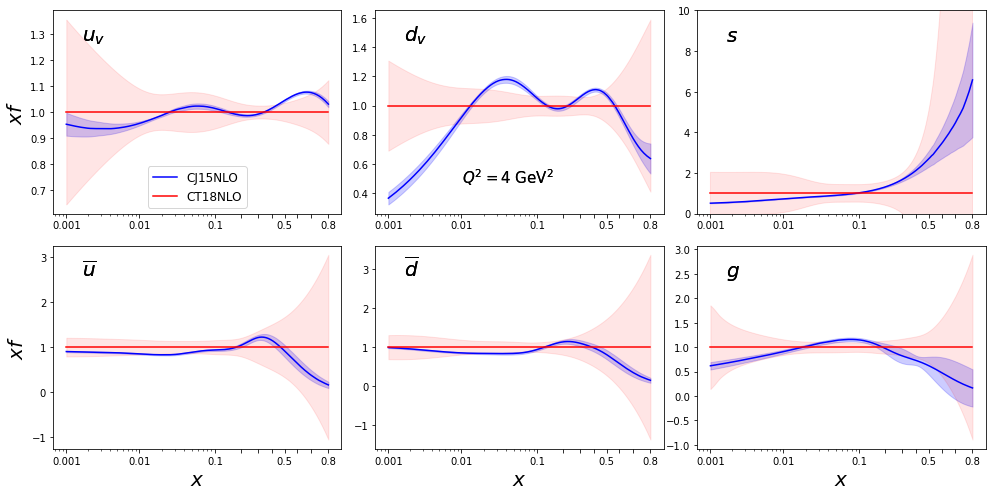

In [5]:
mypdfs = [[ cj15nlo, "blue", "-", "CJ15NLO", True, 0.2], #pdf, color, linestyle, label, fullnuc, error, allpha
         [ct18nlo, "red", "-", "CT18NLO", True, 0.1], #pdf, color, linestyle, label, fullnuc, error, allpha
]

flavors = ["uv", "dv", "s", "ubar", "dbar", "g"]
Q = 1.3
#xlist = np.linspace(0.001, 1.0,500)
xlist = np.logspace(-3,np.log10(0.8),300)
plt.figure(1,figsize=(14,7))
for iflv, flv in enumerate(flavors) :
    ax=plt.subplot2grid((2,3),(int(iflv/3), iflv%3))   
    plt.tight_layout()
    #plt.axhline(1.0, linestyle="dotted")
    #plt.axhline(0.0, linestyle="dotted")
    for pdf in mypdfs : 
        data, dp, dm = pdf[0].getPDFerrors(xlist, Q, flv)
        data_cteq=ct18nlo.getPDFerrors(xlist, Q, flv)[0]
        plt.plot(xlist, (data/data_cteq), color=pdf[1], linestyle=pdf[2], label = pdf[3])

        if (pdf[4]) : 
            plt.fill_between(xlist, ((data+dp)/data_cteq), ((data-dp)/data_cteq), color=pdf[1], alpha=pdf[5])

        flvlabel = "$"+flv+"$"
        if (flv == "uv") : 
            flvlabel = "$u_v$"
        elif (flv =="dv") : 
            flvlabel= "$d_v$"
        elif flv=="ubar" : 
            flvlabel = r"$\overline{u}$"
        elif flv=="dbar" : 
            flvlabel = r"$\overline{d}$"
        elif flv=="ssb" : 
            flvlabel = r"$s+\overline{s}$"


        plt.xscale("logit" ,one_half="0.5")
        if int(iflv/3)==1 : 
            plt.xlabel(r'${x}$',fontsize=20)
        if (iflv%3 ==0) : 
            plt.ylabel(r'${xf}$',fontsize=20, rotation=90)
        plt.annotate(flvlabel, xy=(0.1, 0.85), xycoords='axes fraction', fontsize=20)

        
        
        if (flv!="s") : 
            pass #plt.ylim(0.6, 1.4)
        else : 
            plt.ylim(0., 10)

        if (iflv==0):
            plt.legend(loc="lower center", fontsize=12)
        if (iflv == 1) : 
            plt.annotate("$Q^2={}\ \mathrm{{GeV}}^2$".format(4), xy=(0.3, 0.15), xycoords='axes fraction', fontsize=15)
        ax.set_xticks([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
        ax.set_xticklabels(["0.001", "0.01", "0.1","", "", "", "0.5","", "", "0.8"])
        ax.xaxis.set_minor_formatter(NullFormatter())
        
plt.savefig("pdf.pdf", bbox_inches="tight")

## Fit CJ15 Parameterization

In [33]:
data_flv = ["uv", "dv", "g", "s", "u", "ubar", "d", "dbar"]
ct18 = PDFdata("CT18NLO", flvs=data_flv, xmin=1e-5, xmax = 0.8, Q0=1.3)
paramCJori =  CJ15ParamOri  (xmin=1e-6)
parName = list(paramCJori.paramDict.keys())#list(pars.keys()) #  #
parVal = list(paramCJori.paramDict.values())## list(pars.values())#
oplist = parName#['dboub0', 'dboub1', 'dboub2', 'dboub3', 'dboub4'
init = parVal#[(-10*abs(p), 10*abs(p)) for p in parVal]
chi2= Chi2Fit(ct18, paramCJori, oplist)
fitParams_cjori =chi2.fit(init, local= True)

LHAPDF 6.5.1 loading all 59 PDFs in set CT18NLO
CT18NLO, version 1; 59 PDF members
initial chi2, chi2/N :   9502.299376309213 9.136826323374242
chi2/N 9.136826328231106
chi2 :  9502.299375382128 9.136826322482817
param :  [ 0.65142925  3.63026571 -0.4940881   3.21811491  0.67884919  5.71582971
 -1.41094974  5.55664633  0.06263265  0.71702499  0.39734831  0.41082076
  4.88495234 -3.11728867  2.94682751 -0.18456645  5.79274859  3.0988133
 -3.35745703  0.49986057 -0.25578466  8.65164857 -2.43762659  1.84438266
  1.61709895 17.00422068  6.69639491  2.51482433  6.38960389  4.84851572]


## Fit CJ15 Extended Parameetrization

In [7]:
paramCJ =  CJ15Param  (xmin=1e-6)
parName = list(paramCJ.paramDict.keys())#list(pars.keys()) #  #
parVal = list(paramCJ.paramDict.values())## list(pars.values())#
oplist = parName#['dboub0', 'dboub1', 'dboub2', 'dboub3', 'dboub4'
init = parVal#[(-10*abs(p), 10*abs(p)) for p in parVal]
chi2= Chi2Fit(ct18, paramCJ, oplist)
fitParams_cj=chi2.fit(init, local= True)

initial chi2, chi2/N :   24458.7506261593 23.518029448230095
chi2/N 3.6279335732551448
chi2/N 3.5764211121517784
chi2/N 3.5394895650739326
chi2/N 3.498511072522362
chi2 :  3371.62376937777 3.2419459320940094
param :  [ 6.74069677e-01  3.08942155e+00 -1.97739557e+00  6.97851965e+00
 -5.22206385e+00  6.81247606e-01  5.71811184e+00 -1.36491560e+00
  5.62793785e+00  6.75919429e-02  5.50445269e-03  3.92342680e-01
  4.18079338e-01  4.71783132e+00 -3.47235076e+00  4.13044182e+00
 -1.09225693e+00 -2.15442840e-01  5.72251910e+00  7.13393255e+00
 -1.14733530e+01  4.54523181e+00  4.74482916e-01 -1.77528938e-01
  8.77282399e+00 -4.07615388e+00  2.49881626e+01 -2.79336462e+00
 -4.24082549e-02 -2.23615010e-02  3.68984546e-01  7.88523615e+00
  5.68627020e+00 -5.61167304e+00]


## CTEQ6 Parameterization

In [8]:
parName = [
        'uv1', 'uv2', 'uv3', 'uv4', 'uv5', 
        'dv1', 'dv2', 'dv3', 'dv4', 'dv5', 
        'gsum', 'g1', 'g2', 'g3', 'g4', 'g5',
         'ubdb1', 'ubdb2', 'ubdb3', 'ubdb4', 'ubdb5', 
         'ssbsum', 'ssb1', 'ssb2', 'ssb3', 'ssb4', 'ssb5',
          'dboub0', 'dboub1', 'dboub2', 'dboub3', 'dboub4']
parVal =[  0.58548434,   3.02430526,  -3.40345705,   0.81209935,
         3.22115537,   0.64064233,   2.94284716, -19.5171162 ,
        -0.82452876,  47.93094122,   0.39028395,   0.40258985,
         6.8401196 ,  16.71164947,   1.39709066,  -7.33133226,
        -0.17255835,   5.51676097,  -2.18902863,   4.34714483,
         0.30650973,   0.4849825 ,  -0.08425687,  16.75963656,
        12.6947026 ,  11.69188116,  -0.15743712,   0.54212493,
         2.10409142,   0.13261703,   9.03566941,   3.84404106]
paramCTEQ = CTEQParam()
parName = list(paramCTEQ.paramDict.keys())#list(pars.keys()) #  #
parVal = list(paramCTEQ.paramDict.values())## list(pars.values())#
paramCTEQ.setParameter(parName, parVal)
oplist = parName#['dboub0', 'dboub1', 'dboub2', 'dboub3', 'dboub4']
init = parVal#[ 0.0  ,  4.0249 , 2. , 1.8 , 0.6 ]
#init = scipy.optimize.Bounds ([0, -5, -50, -50, -100], [10, 5,50, 50, 100])  #[(0.0, 10.0), (-5.5), (-50,50), (-50, 50), (-100,100)]

chi2= Chi2Fit(ct18, paramCTEQ, oplist)
fitParams_cteq=chi2.fit(init, True,   local=True)

initial chi2, chi2/N :   24003.216926995636 23.08001627595734


/home/muzakka/anaconda3/envs/Conda37/lib/python3.7/site-packages/ipykernel_launcher.py:210: RuntimeWarning: overflow encountered in double_scalars
/home/muzakka/anaconda3/envs/Conda37/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in double_scalars
/home/muzakka/anaconda3/envs/Conda37/lib/python3.7/site-packages/ipykernel_launcher.py:210: RuntimeWarning: invalid value encountered in double_scalars


chi2/N 14.816638853614911
chi2/N 14.551377096240966
chi2/N 14.420230867730524
chi2/N 14.222438540121502


/home/muzakka/anaconda3/envs/Conda37/lib/python3.7/site-packages/ipykernel_launcher.py:58: IntegrationWarning: The integral is probably divergent, or slowly convergent.
/home/muzakka/anaconda3/envs/Conda37/lib/python3.7/site-packages/ipykernel_launcher.py:58: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.


chi2/N 6.687448487984607
chi2/N 5.845616670601508
chi2/N 5.813766919071052
chi2/N 5.793049994104538
chi2/N 5.776019309861734
chi2/N 5.759966746096579
chi2/N 5.748751748147264
chi2/N 5.741731290769436
chi2/N 5.736302203183005
chi2/N 5.73235486436416
chi2/N 5.729144857988629
chi2/N 5.72649875131144
chi2/N 5.724384770817212
chi2/N 5.722609141837289
chi2/N 5.721269044529784
chi2/N 5.720097194090166
chi2 :  5948.9010818563875 5.720097194092681
param :  [ 6.37999970e-01  2.83722922e+00 -3.45483736e+01 -1.95969854e+00
  2.59222121e+02  6.53251027e-01  2.92600620e+00 -5.71418989e+01
 -2.09346692e+00  4.72245044e+02  3.91365971e-01  3.86923057e-01
  6.21574437e+00  1.26042118e+01  1.70512207e+00 -4.89905796e+00
 -1.76797199e-01  5.48756777e+00 -1.98255077e+00  4.62461257e+00
  2.66810672e-01  4.84518126e-01 -2.55971955e-01  8.64807316e+00
 -2.46764569e+00  1.83407714e+00  1.63612529e+00  9.44874168e-01
  2.25050757e+00  3.75071375e-01  9.94549041e+00  4.33090696e+00]


# Plot

LHAPDF 6.5.1 loading all 59 PDFs in set CT18NLO
CT18NLO, version 1; 59 PDF members


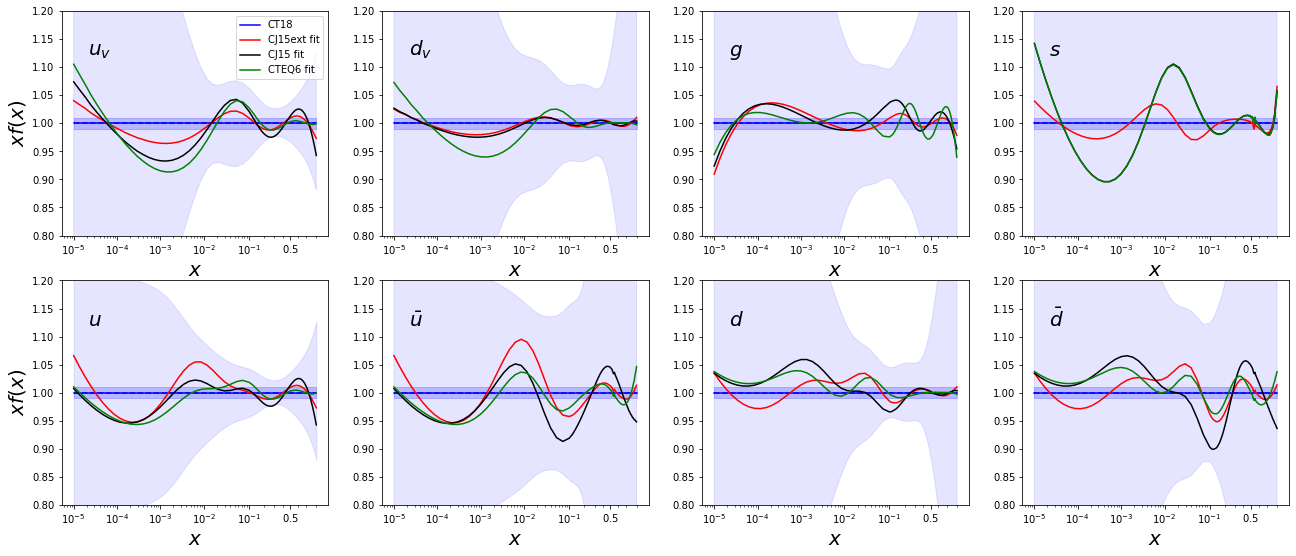

In [30]:
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
#cj15 = PDFdata("CJ15nlo", flvs=data_flv, xmin=1e-6)
#xlist_cj15 = cj15.xlist
#ct14 =  PDFdata("CT14nlo_1_1", flvs=data_flv, xmin=1e-6) 
CT18_pdfs= PDFs("CT18NLO","sym", 1, 1, False)
xlist = ct18.xlist
xrbf = [1e-9, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2,  0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0]
plt.figure(figsize=[22, 19])
for i, flv in enumerate(data_flv) : 
    plt.subplot2grid((4,4), ( int(i/4), i%4))
    data = ct18.data[flv][0]
    err = ct18.data[flv][1]
    data_denom=data
    ct18_dt = CT18_pdfs.getPDFerrors(xlist, 1.295, flv)


    plt.plot(xlist, data/data_denom, color="blue", label="CT18")
    plt.fill_between(xlist, (data+err)/data_denom, (data-err)/data_denom, color="blue", alpha=0.2)

    plt.plot(xlist, data/data_denom, color="blue", linestyle="dashed")
    plt.fill_between(xlist, (ct18_dt[0]+ ct18_dt[1])/data_denom, (ct18_dt[0]-ct18_dt[2])/data_denom, color="blue", alpha=0.1)

    """ 
    data_rbf = np.array([ct18.getPDFatInput(x, flv) for x in xrbf])
    rbf =  interp1d(xrbf, data_rbf, kind='quadratic',)#, epsilon=3, function="thin_plate", smooth=1e-5) 

    xl = np.linspace(0.1, 0.99, 10
    rbf_pred = np.array([rbf(x) for x in xl])
    data_xl = np.array([ct18.getPDFatInput(x, flv) for x in xl])
    plt.plot(xl, rbf_pred/data_xl, color="black", linestyle="dashed", label="RBF")

    """
    theo_cj = np.array([paramCJ.getXF(x, flv) for x in xlist])
    theo_cteq = np.array([paramCTEQ.getXF(x, flv) for x in xlist])
    theo_cjori = np.array([paramCJori.getXF(x, flv) for x in xlist])

    

    #plt.plot(xlist, theo_cjcteq/data_denom, color="red", label="CJCTEQ fitted")
    plt.plot(xlist, theo_cj/data_denom, color="red", label="CJ15ext fit")
    plt.plot(xlist, theo_cjori/data_denom, color="black", label="CJ15 fit")
    plt.plot(xlist, theo_cteq/data_denom, color="green", label="CTEQ6 fit")
    #plt.plot(xlist, data_ct14/data_denom, color="cyan", label="CT14")
    #plt.plot(xlist, data_cj15/data_denom, color="brown", label="CJ15")
    
    
    txt = "$"+flv+"$" 
    if (flv == "uv") : 
        txt = "$u_v$" 
    elif flv== "dv" : 
        txt = "$d_v$"
    elif flv == "ubar": 
        txt = r"$\bar{u}$"
    elif flv == "dbar" : 
        txt = r"$\bar{d}$"
    plt.annotate(txt,xy=(0.1, 0.8), fontsize=20, xycoords='axes fraction')
    
    plt.xscale("logit", one_half="0.5")
    if flv=="uv" : 
        plt.legend()
    #plt.xlim([0.0001, 0.99])
    plt.ylim([0.8, 1.2])
    plt.xlabel("$x$", fontsize=20)
    if (i%4==0) :
        plt.ylabel("$xf(x)$", fontsize=20)
#plt.subplots_adjust(hspace=0.02, wspace = 0.01)
plt.savefig("CT18fit.pdf", bbox_inches="tight")

In [13]:
paramCTEQ.paramDict

{'uv1': 0.6379999703598204,
 'uv2': 2.8372292202048848,
 'uv3': -34.54837364751325,
 'uv4': -1.9596985437262924,
 'uv5': 259.22212066656795,
 'dv1': 0.6532510267285685,
 'dv2': 2.9260061974625358,
 'dv3': -57.14189888302429,
 'dv4': -2.0934669236560235,
 'dv5': 472.24504428085754,
 'gsum': 0.3913659707594482,
 'g1': 0.3869230570794328,
 'g2': 6.215744365696333,
 'g3': 12.604211817531674,
 'g4': 1.7051220719771225,
 'g5': -4.8990579615526135,
 'ubdb1': -0.17679719850876388,
 'ubdb2': 5.487567765617003,
 'ubdb3': -1.982550765834047,
 'ubdb4': 4.624612567826247,
 'ubdb5': 0.26681067168923417,
 'ssbsum': 0.48451812631445884,
 'ssb1': -0.25597195464771993,
 'ssb2': 8.648073158638748,
 'ssb3': -2.4676456925702075,
 'ssb4': 1.834077139052766,
 'ssb5': 1.636125286186402,
 'dboub0': 0.9448741680146914,
 'dboub1': 2.2505075668810357,
 'dboub2': 0.3750713747649572,
 'dboub3': 9.945490408896271,
 'dboub4': 4.330906959495557}

In [12]:
paramCJ.paramDict

{'uv1': 0.6740696767810838,
 'uv2': 3.0894215477151636,
 'uv3': -1.977395567238814,
 'uv4': 6.978519647373923,
 'uv5': -5.2220638501505166,
 'dv1': 0.681247606446978,
 'dv2': 5.718111835372551,
 'dv3': -1.3649156028318656,
 'dv4': 5.62793784638914,
 'dv5': 0.06759194291014185,
 'dv6': 0.005504452688336558,
 'gsum': 0.3923426795220565,
 'g1': 0.41807933792496554,
 'g2': 4.717831322598054,
 'g3': -3.4723507604918127,
 'g4': 4.1304418157051295,
 'g5': -1.0922569339341643,
 'ubdb1': -0.21544284025048738,
 'ubdb2': 5.722519096130592,
 'ubdb3': 7.13393255141912,
 'ubdb4': -11.47335302670695,
 'ubdb5': 4.5452318082908905,
 'ssbsum': 0.47448291640232626,
 'ssb1': -0.17752893752585944,
 'ssb2': 8.772823990034203,
 'ssb3': -4.07615388035581,
 'ssb4': 24.98816259856356,
 'ssb5': -2.79336462303646,
 'dboub0': -0.04240825492721956,
 'dboub1': -0.022361501009545183,
 'dboub2': 0.36898454628694205,
 'dboub3': 7.885236153940933,
 'dboub4': 5.686270201592956,
 'dboub5': -5.61167304108337}

In [98]:
data_flv = ["uv", "dv", "ubar", "u", "d", "ssb", "g",  "dbar", "ubdb", "dboub"]
#ct18 = PDFdata("CT18NLO_1_1", flvs=data_flv, xmin=1e-5, xmax = 0.9)
ipar = InterpolParam()
parDict = {}
for flv in ipar.basicParams : 
    for i, xi in enumerate(ipar.xnode) : 
        v = ct18.getPDFatInput(xi, flv)
        #print(v)
        parDict[flv+str(i)] = v

parName = list(parDict.keys())
parVal = list(parDict.values())
'''
parVal = [ 3.19826705e-04,  1.43072008e-03,  7.70063452e-03,  3.59475388e-02,
        1.47580877e-01,  3.68092292e-01,  5.31887311e-01,  6.36463788e-01,
        6.95979700e-01,  7.06608912e-01,  6.64256856e-01,  5.26582066e-01,
        3.53710193e-01,  1.97041919e-01,  8.67832569e-02,  2.56697302e-02,
        3.07481026e-03,  3.65579266e-04,  2.50171501e-06,  1.73287925e-04,
        8.49869430e-04,  4.24295008e-03,  1.97785058e-02,  8.41053673e-02,
        2.10997766e-01,  2.94804466e-01,  3.32326871e-01,  3.33279333e-01,
        3.12332209e-01,  2.74598844e-01,  1.84288206e-01,  1.01607826e-01,
        4.63069447e-02,  1.57825924e-02,  3.61807147e-03,  3.37394102e-04,
        3.65277652e-05,  2.56055194e-07,  4.72870734e-02,  1.35881561e-01,
        3.80933222e-01,  9.88876095e-01,  2.02567825e+00,  1.96882244e+00,
        1.42207421e+00,  9.20815790e-01,  6.50205037e-01,  4.82732294e-01,
        3.73038471e-01,  2.35065044e-01,  1.34135246e-01,  6.30799081e-02,
        2.20877682e-02,  4.13519534e-03,  2.13624747e-04,  1.10763937e-05,
        9.03714665e-09,  1.97255239e+00,  1.40223235e+00,  9.96055385e-01,
        6.60759974e-01,  4.68377698e-01,  3.55926622e-01,  2.56927508e-01,
        1.74764739e-01,  1.14478133e-01,  7.25837032e-02,  4.51216557e-02,
        1.62615070e-02,  5.08622395e-03,  1.27467135e-03,  2.17949865e-04,
        1.85382119e-05,  2.70787688e-07,  4.14501550e-09, -2.24573325e-13,
        1.71476888e+00,  1.23971899e+00,  8.32128389e-01,  4.74629289e-01,
        2.19999422e-01,  1.33961880e-01,  9.77065184e-02,  6.17093589e-02,
        3.81475969e-02,  2.24135006e-02,  1.24506085e-02,  3.23611911e-03,
        6.47462854e-04,  8.84200134e-05,  6.93688665e-06,  1.88396662e-07,
        4.12269473e-10,  8.76508116e-13, -1.87855413e-17,  9.80851746e-01,
        1.02556542e+00,  9.42346771e-01,  9.29756743e-01,  1.10430800e+00,
        1.23930006e+00,  1.41041605e+00,  1.49438040e+00,  1.48313391e+00,
        1.41439120e+00,  1.33196554e+00,  1.19611392e+00,  1.13537479e+00,
        1.08641040e+00,  1.08355253e+00,  1.08462869e+00,  1.08203529e+00,
        1.07214919e+00,  1.07349299e+00]
'''      
        
#print((parName),(parVal))
#print(parDict)
ipar.setParameter(parName, parVal)
print(len(parName))

'''
flv="uv"

plt.plot(ct18.xlist, ct18.data[flv][0]/ct18.data[flv][0], label="data")
plt.plot(ct18.xlist, [ipar.getXF(x, flv) for x in ct18.xlist]/ct18.data[flv][0], label="interp")
plt.legend()
#plt.xscale("log")
plt.ylim(0.95, 1.05)
'''

chi2= Chi2Fit(ct18, ipar, parName)
print("chi2/pt : ", chi2.chi2(parVal)/chi2.Npt)
#fitParams_interpol =chi2.fit(parVal, local=True)


/tmp/ipykernel_159050/1192353208.py:36: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  res = integrate.quad(self.getF, self.xmin, self.xmax, "uv", limit=lim)
/tmp/ipykernel_159050/1192353208.py:43: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res = integrate.quad(self.getF, self.xmin, self.xmax, "dv", limit=lim)
/tmp/ipykernel_159050/1192353208.py:64: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res = integrate.quad(self.getXF, self.xmin, self.xmax, "ubdb", limit=lim)
/tmp/ipykernel_159050/1192353208.py:58: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  res = integrate.quad(self.getXF, self.xmin, self.xmax, "ssb", limit=lim)
/tmp/ipykernel_159050/1192353208.py:36: Inte

chi2/N 10.20369745058254


/tmp/ipykernel_159050/1192353208.py:64: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  res = integrate.quad(self.getXF, self.xmin, self.xmax, "ubdb", limit=lim)


chi2/N 7.605849536096757
chi2/N 11.598102842358472
chi2/N 26.032727534449453
chi2/N 5.239089994408776
chi2/N 4.650566883119145
chi2/N 12.46937937700694


/tmp/ipykernel_159050/1192353208.py:59: RuntimeWarning: overflow encountered in double_scalars
  self.paramNorm["ssb0"] =self.paramDict["ssbsum"]*rem/(3*res[0])


chi2/N 1.579091618316252


/tmp/ipykernel_159050/1192353208.py:59: RuntimeWarning: divide by zero encountered in double_scalars
  self.paramNorm["ssb0"] =self.paramDict["ssbsum"]*rem/(3*res[0])
/tmp/ipykernel_159050/1192353208.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*np.e**(self.paramDict["ssb3"]*x)*(1+np.e**self.paramDict["ssb4"]*x)**self.paramDict["ssb5"]


chi2/N 1.4588389826909525
chi2/N 1.5212711367153353


/tmp/ipykernel_159050/1192353208.py:322: RuntimeWarning: overflow encountered in double_scalars
  return s0*x**self.paramDict["ssb1"]*(1-x)**self.paramDict["ssb2"]*np.e**(self.paramDict["ssb3"]*x)*(1+np.e**self.paramDict["ssb4"]*x)**self.paramDict["ssb5"]


chi2/N 28345.053927977642
chi2/N 0.8479571745960284
chi2/N 0.8440059549649336
chi2/N 0.8092775348915751
chi2/N 3.6502032154432595
chi2/N 8.333333333333334e+96
chi2/N 0.768387531301477
chi2/N 22.13961217193414
chi2/N 0.7631054496964783
chi2/N 0.7625359255155635
chi2/N 0.7713804927115308
chi2/N 8.333333333333334e+96
chi2/N 0.760978405417161
chi2/N 0.7608673731164172
chi2/N 0.7602138149550878
chi2/N 0.7598283304751347
chi2/N 0.7584765625238796
chi2/N 0.7642907181836351
chi2/N 0.7506932128715027
chi2/N 0.7504034642852944
chi2/N 4.926490459789749
chi2/N 0.7500921524800064
chi2/N 0.7483431340599814
chi2/N 0.7467775658826143
chi2/N 0.7453233378601013
chi2/N 0.741653619705453
chi2/N 0.7385149303036936
chi2/N 0.7324771475270896
chi2/N 0.7282183787171628
chi2/N 0.7253896114485701
chi2/N 0.7242808581643937
chi2/N 0.7228736792487418
chi2/N 0.7195011466085078
chi2/N 0.7438051069860537
chi2/N 0.7181169121272835
chi2/N 0.7169960815177777
chi2/N 0.7161080941853488
chi2/N 0.7150846301518213
chi2/N 0.71

LHAPDF 6.5.1 loading all 59 PDFs in set CT18NLO
CT18NLO, version 1; 59 PDF members


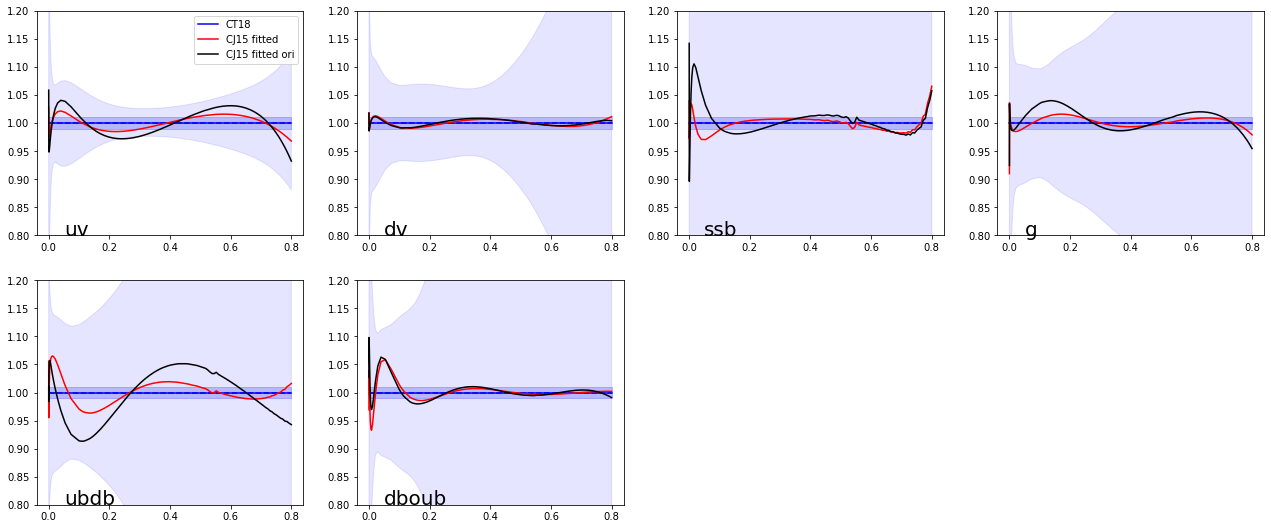

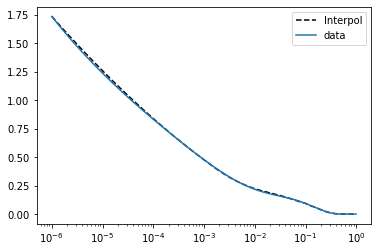

In [60]:
for x, d in zip(xlist, ct18.data["g"][0]) : 
    pass
    #print(x , d)

from sklearn import svm

flv="ssb"
xrbf = [1e-6, 5e-4, 5e-3,0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1.0]
xrbfT = [xTransform(x) for x in xrbf]
data_rbf = np.array([ct18.getPDFatInput(x, flv) for x in xrbf])
rbf = interp1d(xrbfT, data_rbf, kind="quadratic") #
#rbf = interp1d(xrbf, data_rbf, kind="cubic") #
#rbf = UnivariateSpline(xrbf, data_rbf, k=5)
#rbf= Rbf(xrbf, data_rbf, epsilon=3, function="thin_plate", smooth=1e-9) 



xl = xlist #np.linspace(0.1, 0.99, 100)
rbf_pred = np.array([rbf(xTransform(x)) for x in xl])
#rbf_pred = np.array([rbf(x) for x in xl])
data_xl = np.array([ct18.getPDFatInput(x, flv) for x in xl])
plt.plot(xl, rbf_pred, color="black", linestyle="dashed", label="Interpol")


regr = svm.SVR(kernel="poly")
regr.fit([[x] for x in xrbf], data_rbf)
xp = [[x] for x in xl]
#plt.plot(xlist, regr.predict(xp), color="green", label="SMV")


#regr = MLPRegressor(random_state=1, max_iter=5000000, hidden_layer_sizes=(300, ), activation="tanh").fit([[x] for x in xl], data_xl)
#plt.plot(xlist, regr.predict(xp), color="cyan", label="NN")

plt.plot(xlist, [ct18.getPDFatInput(x, flv) for x in xlist], label="data")
plt.xscale("log")
#plt.ylim([0.9, 1.1])
#plt.xlim(0.0, 0.97)
plt.legend()
plt.show()

[-6.0, -5.0, -3.0, -1.3010299956639813, -1.0, 0.11111111111111116, 1.2222222222222219, 2.333333333333334, 3.4444444444444446, 4.555555555555555, 5.666666666666666, 6.777777777777779, 7.888888888888889, 9.0]


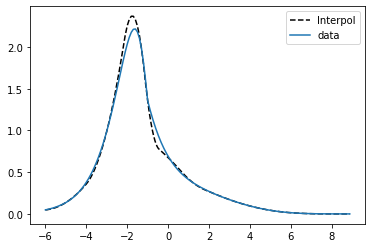

In [43]:
for x, d in zip(xlist, ct18.data["g"][0]) : 
    pass
    #print(x , d)

from sklearn import svm
plt.figure()

xrbfT = [xTransform(x) for x in xrbf]
print(xrbfT)
data_rbf = np.array([ct18.getPDFatInput(x, flv) for x in xrbf])
rbf = interp1d(xrbfT, data_rbf, kind="quadratic") 

xl = [xTransform(x) for x in xlist]
rbf_pred = np.array([rbf(xp) for xp in xl])
plt.plot(xl, rbf_pred, color="black", linestyle="dashed", label="Interpol")


plt.plot(xl, [ct18.getPDFatInput(x, flv) for x in xlist], label="data")
#plt.xscale("log")
#plt.ylim([0.9, 1.1])
#plt.xlim(0.0, 0.97)
plt.legend()
plt.show()

LHAPDF 6.2.3 loading all 59 PDFs in set CT18NLO_1_1
CT18NLO_1_1, version 1; 59 PDF members
1589171045914.37


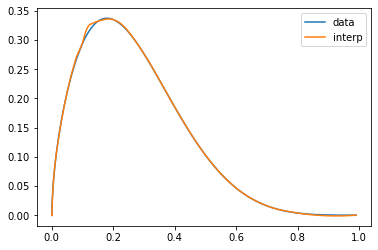

In [18]:
fitParams_cj
#print(paramCJ.paramDict)

array([  0.58352258,   3.0200455 ,  -3.45434444,   0.80492037,
         3.27415955,   0.64077935,   2.93923544, -20.2189565 ,
        -0.86671114,  51.62299289,   0.38980863,   0.45392451,
         4.39375266,  -3.93845204,   5.58236062,  -2.42381987,
        -0.20465331,   5.88906456,   6.38116163,  -8.23562638,
         2.37949828,   0.47689078,  -0.19810218,   3.18634066,
        -3.46187537,  13.13834543, -20.98917244,  -7.27860234,
        15.91196502,  34.30283822,   6.59245209,   4.63824961])

In [19]:
fitParams
#print(paramCJ.paramDict)

array([  0.58548434,   3.02430526,  -3.40345705,   0.81209935,
         3.22115537,   0.64064233,   2.94284716, -19.5171162 ,
        -0.82452876,  47.93094122,   0.39028395,   0.40258985,
         6.8401196 ,  16.71164947,   1.39709066,  -7.33133226,
        -0.17255835,   5.51676097,  -2.18902863,   4.34714483,
         0.30650973,   0.4849825 ,  -0.08425687,  16.75963656,
        12.6947026 ,  11.69188116,  -0.15743712,   0.54212493,
         2.10409142,   0.13261703,   9.03566941,   3.84404106])

LHAPDF 6.2.3 loading all 55 PDFs in set BaseDimuNeu_1_1
BaseDimuNeu_1_1, version 1; 55 PDF members
Warning, some error in flavor  uv contains zero errors!
Warning, some error in flavor  dv contains zero errors!
Warning, some error in flavor  ubdb contains zero errors!
Warning, some error in flavor  ssb contains zero errors!
Warning, some error in flavor  g contains zero errors!
Warning, some error in flavor  dboub contains zero errors!
Warning, some error in flavor  u contains zero errors!
Warning, some error in flavor  d contains zero errors!
Warning, some error in flavor  ubar contains zero errors!
Warning, some error in flavor  dbar contains zero errors!
Warning, some error in flavor  s contains zero errors!


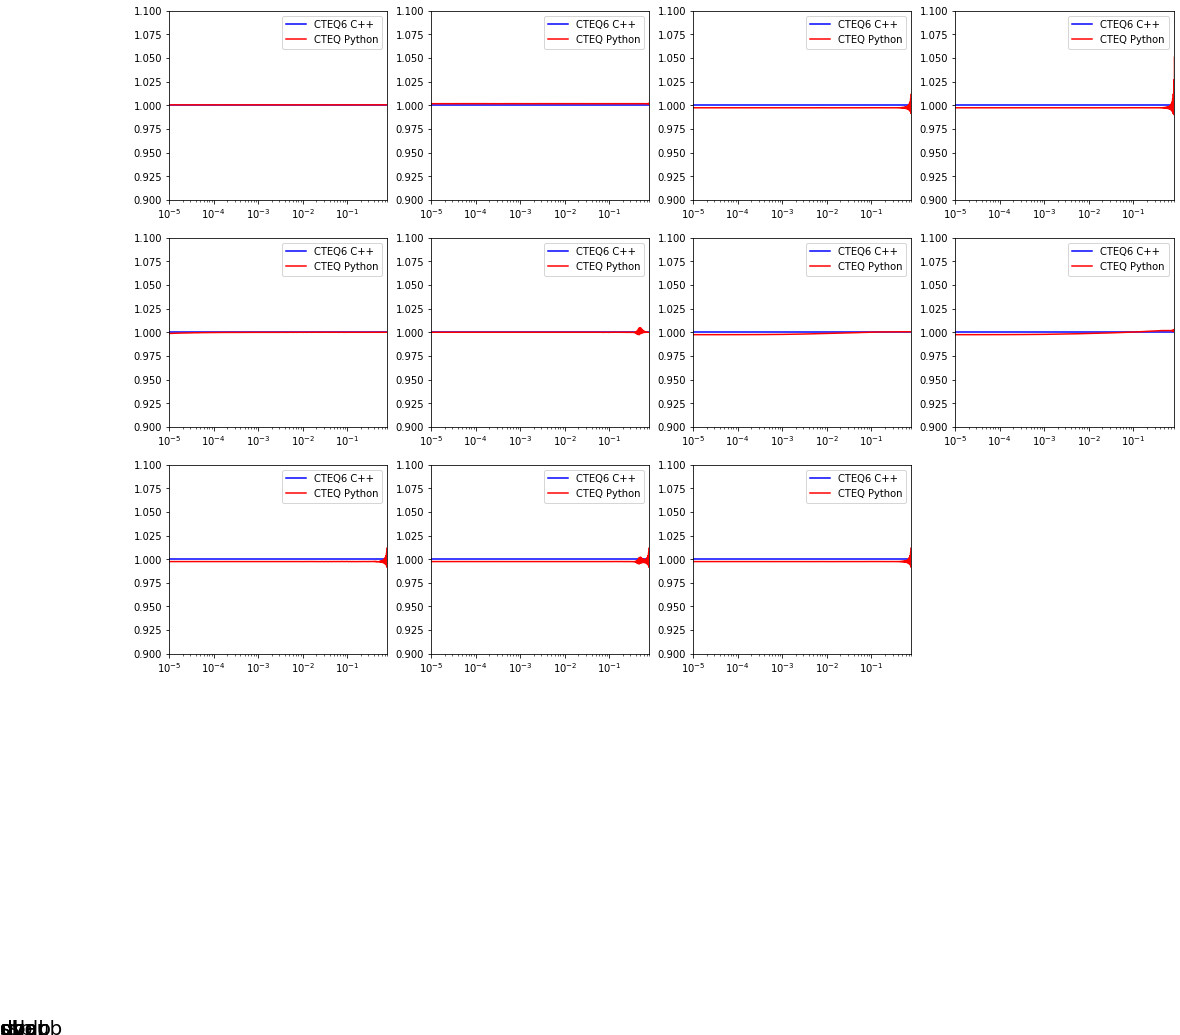

In [39]:
data_flv = ["uv", "dv", "ubdb", "ssb", "g",  "dboub", "u", "d", "ubar", "dbar", "s"]
paramCTEQ_ori = CTEQParam(xmin=5e-6)
cteqPDF_data = PDFdata("BaseDimuNeu_1_1", Q0=1.30001, xmin=5e-6, flvs=data_flv)
xlist = cteqPDF_data.xlist


plt.figure(figsize=[18, 16])
for i, flv in enumerate(data_flv) : 
    plt.subplot2grid((4,4), ( int(i/4), i%4), )
    data = cteqPDF_data.data[flv][0]
    theo_ori = np.array([paramCTEQ_ori.getXF(x, flv) for x in xlist])
    
    plt.plot(xlist, data/data, color="blue", label="CTEQ6 C++")
    plt.plot(xlist, theo_ori/data, color="red", label="CTEQ Python")
    plt.xlim([0.00001, 0.8])
    plt.ylim([0.9, 1.1])
    #plt.ylabel(flv, fontsize=15)

    plt.annotate(flv, xy=(0.1, 0.8), xycoords="figure points", fontsize=20)
    plt.xscale("log")
    plt.legend()


In [43]:
paramDict={
            "uv1":0.63002, "uv2" : 2.93351, "uv3":-2.36916, "uv4":1.26642, "uv5" : 1.71840,
            "dv1":0.51328, "dv2" : 4.21144, "dv3": -2.37454, "dv4":0.96497, "dv5" : 3.0,
            "gsum":0.38232, "g1":0.52256, "g2" : 3.03369, "g3": 4.39448, "g4":2.35917, "g5": -3.00000,
            "ubdb1":-0.32390, "ubdb2" :8.11550, "ubdb3": 0.41321, "ubdb4":4.75394, "ubdb5" :0.61366,
            "ssbsum":0.5, "ssb1":-0.32390, "ssb2" : 8.11550, "ssb3": 0.41321, "ssb4":4.75394, "ssb5" :  0.61366, 
            "dboub0":10.07478, "dboub1" :4.95673, "dboub2": 15.16661, "dboub3":17.00000, "dboub4" : 9.94806
        }
print(list(paramDict.values()))

[0.63002, 2.93351, -2.36916, 1.26642, 1.7184, 0.51328, 4.21144, -2.37454, 0.96497, 3.0, 0.38232, 0.52256, 3.03369, 4.39448, 2.35917, -3.0, -0.3239, 8.1155, 0.41321, 4.75394, 0.61366, 0.5, -0.3239, 8.1155, 0.41321, 4.75394, 0.61366, 10.07478, 4.95673, 15.16661, 17.0, 9.94806]


In [186]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

In [187]:
X, y = make_regression(n_samples=200, random_state=1)

200